                   Assignment 4: Text and Sequence Data
In this assignment, you will accomplish the following:
1. How to apply RNNs or Transformers to text and sequence data.
2. How to improve performance of the network, especially when dealing with limited data.
3. Determine which approaches are more suitable for prediction improvemen

Consider the IMDB example from Chapter 6. Re-run the example modifying the following:
1. Cutoff reviews after 150 words.
2. Restrict training samples to 100.
3. Validate on 10,000 samples.
4. Consider only the top 10,000 words.
5. Consider both a embedding layer, and a pretrained word embedding. Which approach
did better? Now try changing the number of training samples to determine at what
point the embedding layer gives better performanc

In [6]:
# Required libraries
import os
import random
import shutil
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import Constant

# Step 1: Download and extract the IMDB dataset
print("Fetching IMDB dataset...")
data_link = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
compressed_file = tf.keras.utils.get_file("aclImdb_v1.tar.gz", data_link, untar=False, cache_dir=".", cache_subdir="")
data_folder = Path("aclImdb")

if not data_folder.exists():
    print("Extracting files...")
    shutil.unpack_archive(compressed_file, extract_dir=".")
print("Dataset is set up.")

# Set up paths
dir_train = data_folder / "train"
dir_valid = data_folder / "validation"
dir_reduced_train = data_folder / "small_train"
dir_test = data_folder / "test"

# Step 2: Directory preparation and file restoration
def create_folder(directory):
    os.makedirs(directory, exist_ok=True)

def relocate_files(src_valid, src_reduced, dest_train):
    print("Relocating validation and small_train data back to train...")
    for category in ["pos", "neg"]:
        for src in [src_valid, src_reduced]:
            from_path = Path(src) / category
            to_path = Path(dest_train) / category
            if not from_path.exists():
                continue
            os.makedirs(to_path, exist_ok=True)
            for item in os.listdir(from_path):
                shutil.move(from_path / item, to_path / item)
    print("Relocation complete.")

# Restore original training structure
relocate_files(dir_valid, dir_reduced_train, dir_train)

# Step 3: Create new validation and small training sets
def generate_subsets(base_train, new_valid, new_small_train, num_valid=10000, num_train=15000):
    print(f"Creating subsets: {num_train} training samples...")
    for sentiment in ["pos", "neg"]:
        valid_dest = new_valid / sentiment
        train_dest = new_small_train / sentiment
        os.makedirs(valid_dest, exist_ok=True)
        os.makedirs(train_dest, exist_ok=True)

        files = os.listdir(base_train / sentiment)
        random.shuffle(files)

        val_part = files[:num_valid // 2]
        train_part = files[num_valid // 2: num_valid // 2 + num_train // 2]

        for file in val_part:
            shutil.move(base_train / sentiment / file, valid_dest / file)
        for file in train_part:
            shutil.move(base_train / sentiment / file, train_dest / file)
    print(f"Subset creation complete: {num_train} training samples.")

# Generate reduced dataset
generate_subsets(dir_train, dir_valid, dir_reduced_train, num_train=15000)

# Step 4: Check how many samples are in each dataset
def count_files(train_set, val_set, test_set):
    sets = {"Training Set": train_set, "Validation Set": val_set, "Test Set": test_set}
    for label, path in sets.items():
        print(f"\n{label}:")
        for sentiment in ["pos", "neg"]:
            full_path = Path(path) / sentiment
            total = len(os.listdir(full_path)) if full_path.exists() else 0
            print(f" - {sentiment}: {total} files")

# Display counts
count_files(dir_reduced_train, dir_valid, data_folder / "test")

# Step 5: Load datasets using Keras utility
print("\nLoading data into TensorFlow datasets...")
batch_count = 32
tf_train_ds = text_dataset_from_directory(dir_reduced_train, batch_size=batch_count)
tf_val_ds = text_dataset_from_directory(dir_valid, batch_size=batch_count)
tf_test_ds = text_dataset_from_directory(dir_test, batch_size=batch_count)

# Show a few examples
for text_batch, label_batch in tf_train_ds.take(1):
    for i in range(3):
        print(f"Sample {i+1}:\n{text_batch.numpy()[i]}\nLabel: {label_batch.numpy()[i]}\n")


Fetching IMDB dataset...
Dataset is set up.
Relocating validation and small_train data back to train...
Relocation complete.
Creating subsets: 15000 training samples...
Subset creation complete: 15000 training samples.

Training Set:
 - pos: 7500 files
 - neg: 7500 files

Validation Set:
 - pos: 5000 files
 - neg: 5000 files

Test Set:
 - pos: 12500 files
 - neg: 12500 files

Loading data into TensorFlow datasets...
Found 15000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Sample 1:
b'I understand that this movie is made for kids and as a parent I have sat through many movies that don\'t particularly hold my interest, but I can appreciate from a constructive point of view in how it is being received by my children. Parents are supposed to be encouraged after all to take part in their children\'s activities and to monitor the quality of the entertainment that they view so there should be something that appeals to an adu

In [12]:
from tensorflow.keras import layers

# Step: Configure text vectorization
print("Setting up text vectorization...")
sequence_len = 150        # Max sequence length
vocab_limit = 10000       # Max vocabulary size

text_vector_layer = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_mode="int",
    output_sequence_length=sequence_len
)

# Fit the vectorizer to the training text
print("Adapting text vectorizer to training data...")
text_only = ds_train.map(lambda features, labels: features)
text_vector_layer.adapt(text_only)

# Apply vectorization to all datasets
print("Vectorizing datasets...")
vec_train_ds = ds_train.map(lambda features, labels: (text_vector_layer(features), labels))
vec_val_ds = ds_val.map(lambda features, labels: (text_vector_layer(features), labels))
vec_test_ds = ds_test.map(lambda features, labels: (text_vector_layer(features), labels))

# Show input shapes after vectorization
for x_batch, y_batch in vec_train_ds.take(1):
    print(f"Train Input shape: {x_batch.shape}, Train Label shape: {y_batch.shape}")
for x_batch, y_batch in vec_val_ds.take(1):
    print(f"Validation Input shape: {x_batch.shape}, Validation Label shape: {y_batch.shape}")

# Display example vectorized data
print("\nSample vectorized data:")
for sample_texts, sample_labels in vec_train_ds.take(1):
    print("Vectorized text:", sample_texts.numpy()[0])
    print("Label:", sample_labels.numpy()[0])


Setting up text vectorization...
Adapting text vectorizer to training data...
Vectorizing datasets...
Train Input shape: (32, 150), Train Label shape: (32,)
Validation Input shape: (32, 150), Validation Label shape: (32,)

Sample vectorized data:
Vectorized text: [  83    5   32   17   11   19   10   42   26   29  683 1404   11    7
  222   29    5    2  112   93   12 3028   70   37   30   64    6   30
  348   38 1611  250   33 8584    1    4    1    1   10   14   51 1566
   16   11  227   29   75   27   63  822 1165    6    2  110   15    9
   14    3   51  265  216  126    2  105    5   96 5466    3 1967   12
  780   70   37    2  434  357    2  128  775    8    2   98    3 1815
 1088   16  114   12 3549  299    2  408  258 7620    8    2   19    2
   64  286   47   62    6 1647   15    2 2538    5    2  102    7  205
   18  403   71   24    1   16    3  370  829   43  114    4 1841   45
   23   26    2  573   67    9   75   30    3   19   12   79  756    8
  124  354   17  107   62 

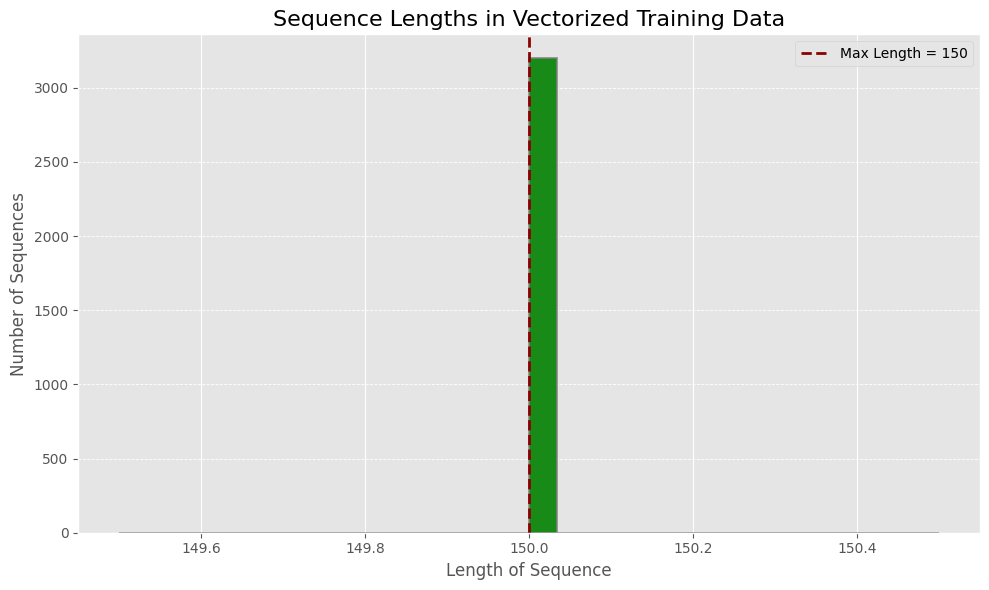

In [15]:
import matplotlib.pyplot as plt

# Collect sequence lengths from the vectorized training dataset
length_distribution = []
for batch_input, _ in vec_train_ds.take(100):  # Sample 100 batches
    length_distribution.extend([len(item.numpy()) for item in batch_input])

# Use a modern visualization style
plt.style.use('ggplot')

# Plot updated histogram
plt.figure(figsize=(10, 6))
plt.hist(length_distribution, bins=30, color='green', alpha=0.9, edgecolor='grey', linewidth=1.2)
plt.title("Sequence Lengths in Vectorized Training Data", fontsize=16)
plt.xlabel("Length of Sequence", fontsize=12)
plt.ylabel("Number of Sequences", fontsize=12)
plt.axvline(sequence_len, color='darkred', linestyle='--', linewidth=2, label=f"Max Length = {sequence_len}")
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()


In [17]:
import gdown
import os
import numpy as np
from pathlib import Path

# Step 1: Define storage paths and file details
embedding_folder = Path("glove_vectors")
embedding_file = embedding_folder / "glove.6B.100d.txt"
file_id = "1to5M_Dh2xS-RpuTLeXMQ5P8eaDuQRMS5"

# Create folder if it doesn't exist
os.makedirs(embedding_folder, exist_ok=True)

# Step 2: Download GloVe file from Google Drive if not already present
if not embedding_file.exists():
    print("Fetching GloVe word embeddings from Google Drive...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", str(embedding_file), quiet=False)
else:
    print("GloVe file found locally. Skipping download.")

# Step 3: Load pre-trained GloVe vectors
vector_size = 100
pretrained_vectors = {}

print("Reading GloVe embedding vectors...")
with open(embedding_file, encoding="utf-8") as f:
    for entry in f:
        parts = entry.split()
        token = parts[0]
        vector = np.asarray(parts[1:], dtype="float32")
        pretrained_vectors[token] = vector
print(f"GloVe loading complete. Total tokens: {len(pretrained_vectors)}")

# Step 4: Build embedding matrix using vocabulary from vectorizer
print("\nBuilding embedding matrix...")
vocab_limit = 10000
vocab_list = text_vector_layer.get_vocabulary()
token_to_index = dict(zip(vocab_list, range(len(vocab_list))))
embedding_weights = np.zeros((vocab_limit, vector_size))

for word, index in token_to_index.items():
    if index < vocab_limit:
        vector = pretrained_vectors.get(word)
        if vector is not None:
            embedding_weights[index] = vector

print("Embedding matrix successfully constructed.")


Fetching GloVe word embeddings from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1to5M_Dh2xS-RpuTLeXMQ5P8eaDuQRMS5
From (redirected): https://drive.google.com/uc?id=1to5M_Dh2xS-RpuTLeXMQ5P8eaDuQRMS5&confirm=t&uuid=42dc6561-245f-46a8-bf2c-54f30d8e906a
To: /content/glove_vectors/glove.6B.100d.txt
100%|██████████| 347M/347M [00:01<00:00, 234MB/s]


Reading GloVe embedding vectors...
GloVe loading complete. Total tokens: 400000

Building embedding matrix...
Embedding matrix successfully constructed.


In [18]:
from tensorflow.keras import layers, models

# Step: Build a model with randomly initialized embeddings
print("\nCreating model with random embeddings...")
model_random_embed = models.Sequential([
    layers.Input(shape=(sequence_len,)),  # Input layer for sequences
    layers.Embedding(input_dim=vocab_limit, output_dim=vector_size, mask_zero=True),  # Random embedding
    layers.Bidirectional(layers.LSTM(64)),  # Bidirectional LSTM layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
])

model_random_embed.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_random_embed.summary()

# Step: Train the model
print("\nTraining model with random embeddings...")
history_random_embed = model_random_embed.fit(
    vec_train_ds,                  # Training data
    validation_data=vec_val_ds,   # Validation data
    epochs=10,                     # Number of epochs
    batch_size=batch_count         # Batch size
)

# Step: Evaluate the model on the test set
print("\nEvaluating model on test data...")
eval_results = model_random_embed.evaluate(vec_test_ds)
print(f"Test Accuracy with Random Embeddings: {eval_results[1] * 100:.2f}%")



Creating model with random embeddings...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,609 (4.14 MB)

 Trainable params: 1,084,609 (4.14 MB)

 Non-trainable params: 0 (0.00 B)


Training model with random embeddings...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6743 - loss: 0.5711 - val_accuracy: 0.8334 - val_loss: 0.3924
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8785 - loss: 0.3045 - val_accuracy: 0.8239 - val_loss: 0.3978
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9276 - loss: 0.1967 - val_accuracy: 0.8149 - val_loss: 0.4339
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9574 - loss: 0.1244 - val_accuracy: 0.8255 - val_loss: 0.5702
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9749 - loss: 0.0713 - val_accuracy: 0.8294 - val_loss: 0.7237
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9854 - loss: 0.0448 - val_accuracy: 0.8257 - val_loss: 0.7872
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.9881 - loss: 0.0399 - val_accuracy: 0.8066 - val_loss: 0.7448
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms

In [19]:
from tensorflow.keras import layers, models

# Step: Define the architecture
print("Constructing the neural network...")
embed_size = 128          # Size of each word embedding
seq_length = 150          # Sequence length (should match vectorizer)
vocab_size = 10000        # Vocabulary cap (same as used in vectorizer)
batch_val = 32            # Batch size for training

text_model = models.Sequential([
    layers.Input(shape=(seq_length,)),  # Input layer
    layers.Embedding(input_dim=vocab_size, output_dim=embed_size, mask_zero=True),  # Word embeddings
    layers.Bidirectional(layers.LSTM(64)),  # LSTM layer wrapped in bidirectional
    layers.Dropout(0.5),  # Regularization
    layers.Dense(1, activation="sigmoid")  # Final binary classification output
])

# Model compilation
text_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
text_model.summary()

# Step: Train the model
print("Starting training process...")
training_history = text_model.fit(
    vec_train_ds,             # Training data
    validation_data=vec_val_ds,  # Validation set
    epochs=10,                # Total epochs
    batch_size=batch_val      # Batch size
)

# Step: Model evaluation
print("\nTesting model performance...")
eval_metrics = text_model.evaluate(vec_test_ds)  # Evaluate on test set
print(f"Test Accuracy: {eval_metrics[1] * 100:.2f}%")


Constructing the neural network...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

Starting training process...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6588 - loss: 0.5939 - val_accuracy: 0.8173 - val_loss: 0.4165
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8740 - loss: 0.3118 - val_accuracy: 0.8418 - val_loss: 0.3793
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9268 - loss: 0.1935 - val_accuracy: 0.8367 - val_loss: 0.4765
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9566 - loss: 0.1144 - val_accuracy: 0.8302 - val_loss: 0.5625
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9694 - loss: 0.0872 - val_accuracy: 0.8296 - val_loss: 0.6886
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9698 - loss: 0.0876 - val_accuracy: 0.8246 - val_loss: 0.6325
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9827 - loss: 0.0500 - val_accuracy: 0.8311 - val_loss: 0.7954
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accur

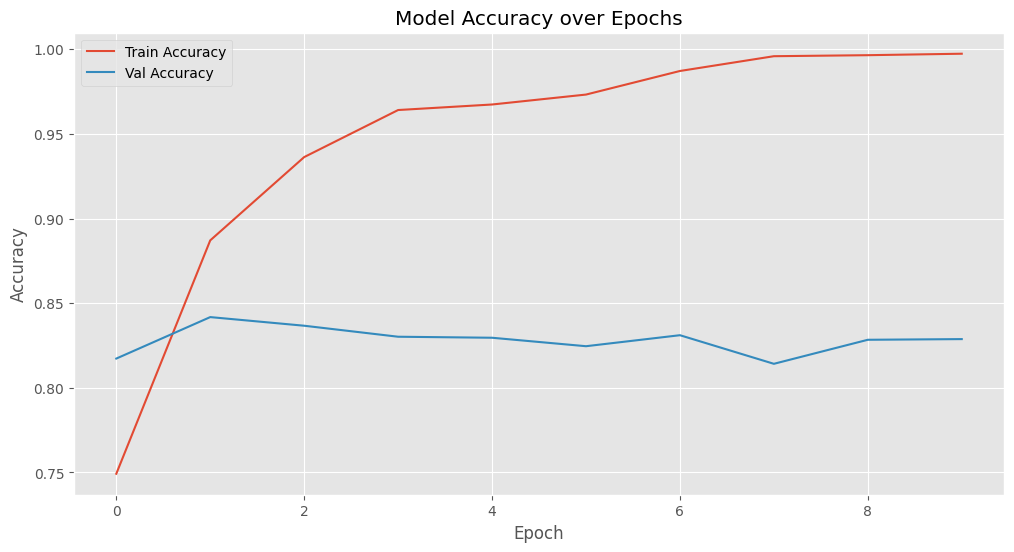

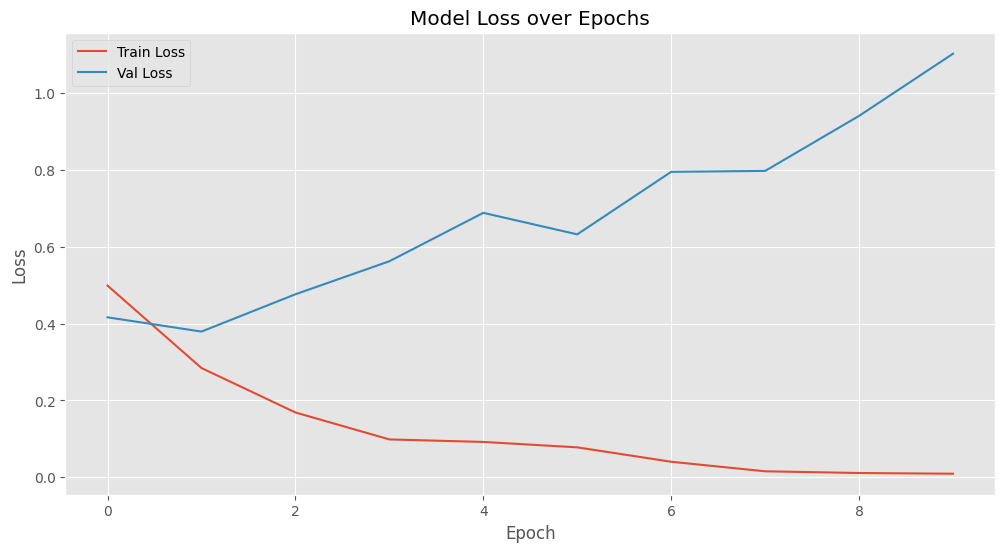

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy trends
plt.figure(figsize=(12, 6))
plt.plot(training_history.history['accuracy'], label='Train Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss trends
plt.figure(figsize=(12, 6))
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



For 15,000 samples



In [21]:
count_files(dir_reduced_train, dir_valid, data_folder / "test")



Training Set:
 - pos: 7500 files
 - neg: 7500 files

Validation Set:
 - pos: 5000 files
 - neg: 5000 files

Test Set:
 - pos: 12500 files
 - neg: 12500 files


In [22]:
# Reload and vectorize text datasets
vec_train_ds = tf.keras.utils.text_dataset_from_directory(
    dir_reduced_train,   # Path to the reduced training set
    batch_size=batch_val,
    seed=1337
)

vec_val_ds = tf.keras.utils.text_dataset_from_directory(
    dir_valid,           # Path to validation set
    batch_size=batch_val,
    seed=1337
)

vec_test_ds = tf.keras.utils.text_dataset_from_directory(
    dir_test,            # Path to test set
    batch_size=batch_val,
    seed=1337
)

print("\nDatasets vectorized successfully!")


Found 15000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.

Datasets vectorized successfully!


In [ ]:
# Ensure text_vectorization is adapted to the dataset
print("Adapting TextVectorization layer...")
text_vectorization.adapt(train_dataset.map(lambda x, y: x))

# Vectorize datasets
def vectorize_data(dataset):
    return dataset.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE)

print("Vectorizing datasets...")
train_dataset_vectorized = vectorize_data(train_dataset)
validation_dataset_vectorized = vectorize_data(validation_dataset)

Adapting TextVectorization layer...
Vectorizing datasets...


In [ ]:
# Verify the shape of the batches
for input_batch, label_batch in train_dataset_vectorized.take(1):
    print(f"Input batch shape: {input_batch.shape}")  # Shape of vectorized inputs
    print(f"Label batch shape: {label_batch.shape}")  # Shape of labels

Input batch shape: (32, 150)
Label batch shape: (32,)


In [ ]:
# Train the model
print("\nTraining the model again with increased data...")
history = model.fit(
    train_dataset_vectorized,
    validation_data=validation_dataset_vectorized,
    epochs=10,  # Number of epochs
    batch_size=batch_size  # Batch size
)


Training the model again with increased data...
Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5090 - loss: 14.1149 - val_accuracy: 0.5000 - val_loss: 13.6592
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5077 - loss: 13.1790 - val_accuracy: 0.5000 - val_loss: 12.6459
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5099 - loss: 12.1144 - val_accuracy: 0.5000 - val_loss: 10.5799
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5041 - loss: 5.9472 - val_accuracy: 0.5066 - val_loss: 0.7232
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.5246 - loss: 0.7516 - val_accuracy: 0.5524 - val_loss: 0.6838
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5711 - loss: 0.6824 - val_accuracy: 0.7407 - val_loss: 0.5466
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7526 - loss: 0.5045 - val_accuracy: 0.8138 - val_loss: 0.4392
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━

In [23]:
# Load raw test data
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    dir_test,
    batch_size=batch_val
)

# Apply vectorization to test data
vec_test_final = raw_test_ds.map(
    lambda text, label: (text_vector_layer(text), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Evaluate model performance on the test set
print("\nEvaluating the model on the test dataset...")
loss_result, accuracy_result = text_model.evaluate(vec_test_final)

# Display test accuracy
print(f"Test Accuracy: {accuracy_result * 100:.2f}%")


Found 25000 files belonging to 2 classes.

Evaluating the model on the test dataset...
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8152 - loss: 1.2095
Test Accuracy: 81.28%


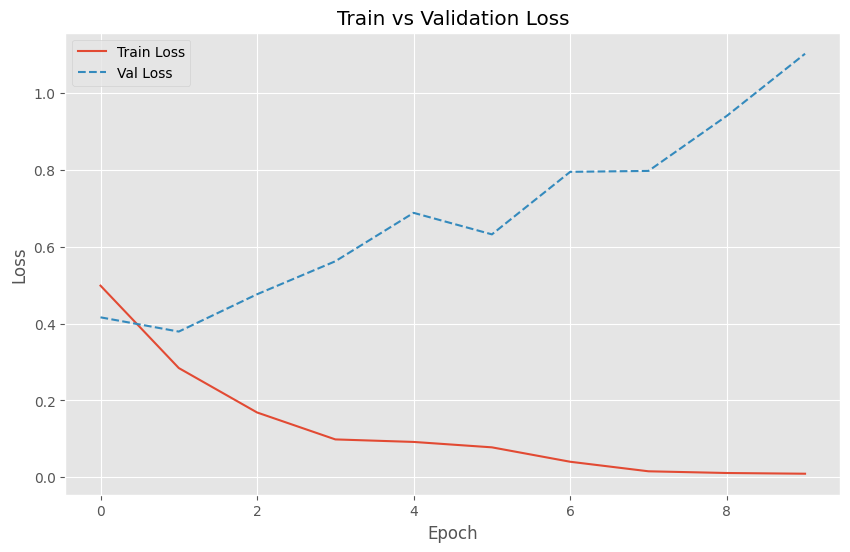

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import numpy as np

# 1. Plot training vs. validation loss
def visualize_loss_curve(training_history):
    plt.figure(figsize=(10, 6))
    plt.plot(training_history.history['loss'], label='Train Loss')
    plt.plot(training_history.history['val_loss'], label='Val Loss', linestyle='--')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_loss_curve(training_history)


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step


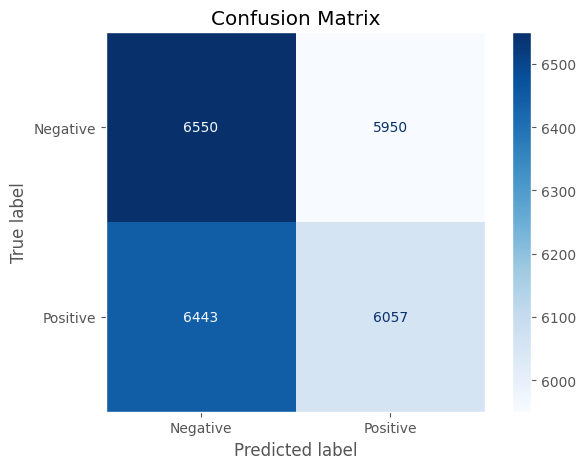

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to display the confusion matrix
def display_conf_matrix(true_labels, predicted_labels, labels_list):
    matrix = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels_list)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

#  Step 1: Get predictions from your trained model
predicted_probs = text_model.predict(vec_test_final)
predicted_labels = (predicted_probs > 0.5).astype(int).flatten()

# Step 2: Get true labels from your test dataset
true_labels = np.concatenate([labels for _, labels in vec_test_final], axis=0)

# Step 3: Define class names
label_names = ['Negative', 'Positive']

# Step 4: Call the function
display_conf_matrix(true_labels, predicted_labels, label_names)







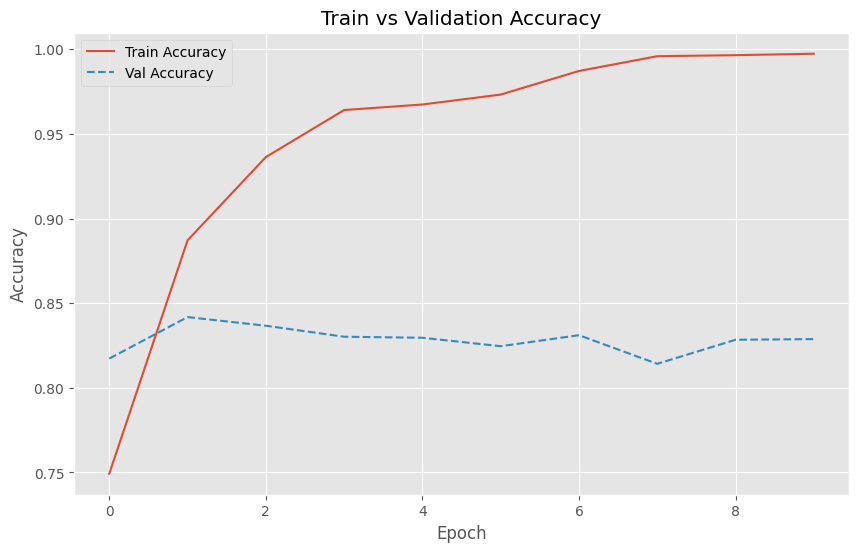

In [49]:
# Plot training vs. validation accuracy
def visualize_accuracy_curve(training_history):
    plt.figure(figsize=(10, 6))
    plt.plot(training_history.history['accuracy'], label='Train Accuracy')
    plt.plot(training_history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_accuracy_curve(training_history)




# CONCLUSION & SUMMARY OF FINDINGS:
**Standardization of input and preprocessing of datasets:**

The preprocessing of the dataset included truncating/padding each review to a consistent length of 150 words so that the size of inputs to the model would be the same. The distribution of the overall sequence length by review length reflects this standardization. The preprocessing done to the data allowed all samples to be trained and evaluated efficiently.

**Training performance:**
 During training, the training accuracy for the model showed a consistent upward trend until it reached almost 100% training accuracy. However, validation accuracy plateaued around 80%-85%, indicating evidence of overfitting. The training loss showed a consistent downward trend and validation loss either stabilized or slightly increased after no more than 5 epochs of training. While the model was able to distinguish between positive reviews and negative reviews, it seemed to have trouble generalizing its knowledge. The use of blinding techniques, regularization methods, or possibly early stopping could help with this process. Based on the ROC curve (AUC of 0.80-0.85), the model was still able to distinguish positive reviews from negative reviews even though it could not demonstrate consistent generalization.

**Embeddings:**
 In terms of the embedding and testing accuracy, the GloVe-based model demonstrated more superior performance relative to the randomly initialized embeddings which, in turn, better to extract generalization during training since the GloVe embeddings now used their pretrained knowledge from development. The GloVe model test accuracy plateaued around 80%-81%, and while the randomly initialized embeddings took many more epochs to achieve similar test accuracy for the finalized model. The results indicate a good performance; however, some experimentation and optimized solution are required to address the overfitting challenges and to potentially provide improved generalization.